# Detecting Fake News with Scikit-Learn

This scikit-learn tutorial will walk you through building a fake news classifier with the help of Bayesian models.

Detecting so-called “fake news” is no easy task. First, there is defining what fake news is – given it has now become a political statement. If you can find or agree upon a definition, then you must collect and properly label real and fake news (hopefully on similar topics to best show clear distinctions). Once collected, you must then find useful features to determine fake from real news.
For a more in-depth look at this problem space, I recommend taking a look at Miguel Martinez-Alvarez’s post “How can Machine Learning and AI Help Solve the Fake News Problem”.
Around the same time I read Miguel’s insightful post, I came across an open data science post about building a successful fake news detector with Bayesian models. The author even created a repository with the dataset of tagged fake and real news examples. I was curious if I could easily reproduce the results, and if I could then determine what the model had learned.
In this tutorial, you’ll walk through some of my initial exploration together and see if you can build a successful fake news detector!
Tip: if you want to learn more about Natural Language Processing (NLP) basics, consider taking the Natural Language Processing Fundamentals in Python course.

In [1]:
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import `fake_or_real_news.csv` 
df = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv")
    
# Inspect shape of `df` 
df.shape

(6335, 4)

In [3]:
# Print first lines of `df` 
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
# Set index 
df = df.set_index("Unnamed: 0")

# Print first lines of `df` 
df.head()

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Extracting the training data

Now that the DataFrame looks closer to what you need, you want to separate the labels and set up training and test datasets.
For this notebook, I decided to focus on using the longer article text. Because I knew I would be using bag-of-words and Term Frequency–Inverse Document Frequency (TF-IDF) to extract features, this seemed like a good choice. Using longer text will hopefully allow for distinct words and features for my real and fake news data.

In [5]:
from sklearn.model_selection import train_test_split

# Set `y` 
y = df.label 

# Drop the `label` column
df.drop("label", axis=1)

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

## Building Vectorizer Classifiers

Now that you have your training and testing data, you can build your classifiers. To get a good idea if the words and tokens in the articles had a significant impact on whether the news was fake or real, you begin by using CountVectorizer and TfidfVectorizer.
You’ll see the example has a max threshhold set at .7 for the TF-IDF vectorizer tfidf_vectorizer using the max_df argument. This removes words which appear in more than 70% of the articles. Also, the built-in stop_words parameter will remove English stop words from the data before making vectors.
There are many more parameters available and you can read all about them in the scikit-learn documentation for TfidfVectorizer and CountVectorizer.


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

Now that you have vectors, you can then take a look at the vector features, stored in count_vectorizer and tfidf_vectorizer.
Are there any noticable issues? (Yes!)
There are clearly comments, measurements or other nonsensical words as well as multilingual articles in the dataset that you have been using. Normally, you would want to spend more time preprocessing this and removing noise, but as this tutorial just showcases a small proof of concept, you will see if the model can overcome the noise and properly classify despite these issues.

In [12]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']
['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000ft', '000km']


## Intermezzo: Count versus TF-IDF Features

I was curious if my count and TF-IDF vectorizers had extracted different tokens. To take a look and compare features, you can extract the vector information back into a DataFrame to use easy Python comparisons.
As you can see by running the cells below, both vectorizers extracted the same tokens, but obviously have different weights. Likely, changing the max_df and min_df of the TF-IDF vectorizer could alter the result and lead to different features in each.

In [13]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4239,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4239,0.0,0.014123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4241,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4242,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

In [16]:
print(count_df.equals(tfidf_df))

False


## Comparing Models

Now it's time to train and test your models.
Here, you'll begin with an NLP favorite, MultinomialNB. You can use this to compare TF-IDF versus bag-of-words. My intuition was that bag-of-words (aka CountVectorizer) would perform better with this model. (For more reading on multinomial distribution and why it works best with integers, check out this fairly succinct explanation from a UPenn statistics course).  

I personally find Confusion Matrices easier to compare and read, so I used the scikit-learn documentation to build some easily-readable confusion matrices (thanks open source!). A confusion matrix shows the proper labels on the main diagonal (top left to bottom right). The other cells show the incorrect labels, often referred to as false positives or false negatives. Depending on your problem, one of these might be more significant. For example, for the fake news problem, is it more important that we don't label real news articles as fake news? If so, we might want to eventually weight our accuracy score to better reflect this concern.  

Other than Confusion Matrices, scikit-learn comes with many ways to visualize and compare your models. One popular way is to use a ROC Curve. There are many other ways to evaluate your model available in the scikit-learn metrics module.

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB() 

accuracy:   0.857
Confusion matrix, without normalization


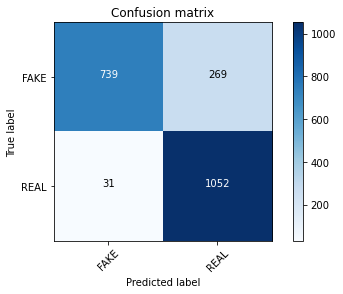

In [22]:
from sklearn import metrics 
import itertools

clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [23]:
clf = MultinomialNB() 

accuracy:   0.893
Confusion matrix, without normalization


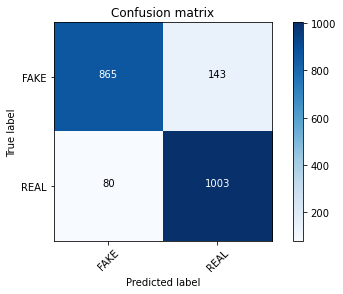

In [24]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

And indeed, with absolutely no parameter tuning, your count vectorized training set count_train is visibly outperforming your TF-IDF vectors!
Testing Linear Models

There are a lot of great write-ups about how linear models work well with TF-IDF vectorizers (take a look at word2vec for classification, SVM reference in scikit-learn text analysis, and many more).
So you should use a SVM, right?
Well, I recently watched Victor Lavrenko's lecture on text classification and he compares Passive Aggressive classifiers to linear SVMs for text classification. We'll test this approach (which has some significant speed benefits and permanent learning disadvantages) with the fake news dataset.

In [27]:
from sklearn.linear_model import PassiveAggressiveClassifier

linear_clf = PassiveAggressiveClassifier()

accuracy:   0.935
Confusion matrix, without normalization


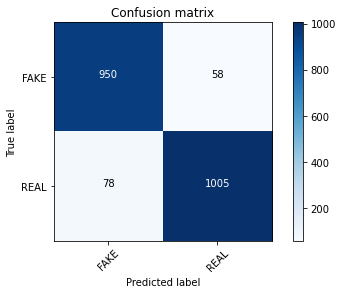

In [28]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

I'm impressed. The confusion matrix looks different and the model classifies our fake news a bit better. We can test if tuning the alpha value for a MultinomialNB creates comparable results. You can also use parameter tuning with grid search for a more exhaustive search.

In [29]:
clf = MultinomialNB(alpha=0.1)

In [30]:
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.88140
Alpha: 0.10 Score: 0.89766
Alpha: 0.20 Score: 0.89383
Alpha: 0.30 Score: 0.89000
Alpha: 0.40 Score: 0.88570
Alpha: 0.50 Score: 0.88427
Alpha: 0.60 Score: 0.87470
Alpha: 0.70 Score: 0.87040
Alpha: 0.80 Score: 0.86609
Alpha: 0.90 Score: 0.85892


/Users/brianroepke/opt/anaconda3/envs/DATA110/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Not quite... At this point, it might be interesting to perform parameter tuning across all of the classifiers, or take a look at some other scikit-learn Bayesian classifiers. You could also test with a Support Vector Machine (SVM) to see if that outperforms the Passive Aggressive classifier.
But I am a bit more curious about what the Passive Aggressive model actually has learned. So let's move onto introspection.

### Introspecting models

So fake news is solved, right? We achieved 93% accuracy on my dataset so let's all close up shop and go home.
Not quite, of course. I am wary at best of these results given how much noise we saw in the features. There is a great write-up on StackOverflow with this incredibly useful function for finding vectors that most affect labels. It only works for binary classificaiton (classifiers with 2 classes), but that's good news for you, since you only have FAKE or REAL labels.
Using your best performing classifier with your TF-IDF vector dataset (tfidf_vectorizer) and Passive Aggressive classifier (linear_clf), inspect the top 30 vectors for fake and real news:

In [32]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)

FAKE -4.9372526318650305 2016
FAKE -4.198892213369002 hillary
FAKE -4.14507516642168 october
FAKE -3.373171356995322 share
FAKE -3.0616760763683866 article
FAKE -3.039801328746935 november
FAKE -2.448078105917512 oct
FAKE -2.391363019072634 email
FAKE -2.3725721343952992 print
FAKE -2.2491915718798503 war
FAKE -2.195355162741934 advertisement
FAKE -2.1691798781289475 source
FAKE -2.1200742849960057 establishment
FAKE -2.11940596157445 mosul
FAKE -2.1093243456745254 podesta
FAKE -2.0600036969175988 election
FAKE -1.952651230715263 corporate
FAKE -1.8243762319758952 nov
FAKE -1.7880407969821857 com
FAKE -1.7812405419777382 donald
FAKE -1.7605892192954635 reuters
FAKE -1.7323279457570058 photo
FAKE -1.731390822352923 26
FAKE -1.7302503101384423 wikileaks
FAKE -1.7120117346000376 pipeline
FAKE -1.7105682100372253 snip
FAKE -1.6816775548409473 ayotte
FAKE -1.6758600215950814 fbi
FAKE -1.6319027757640319 rt
FAKE -1.5599584304118677 entire

REAL 4.6800911631004745 said
REAL 2.6338319932636334

You can also do this in a pretty obvious way with only a few lines of Python, by zipping your coefficients to your features and taking a look at the top and bottom of your list.

In [33]:
feature_names = tfidf_vectorizer.get_feature_names()

In [34]:
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

/Users/brianroepke/opt/anaconda3/envs/DATA110/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[(-6.257361214701583, 'trump'),
 (-6.494453094312678, 'said'),
 (-6.6539784739838845, 'clinton'),
 (-7.037944662867073, 'obama'),
 (-7.146539983381228, 'sanders'),
 (-7.215376008647511, 'president'),
 (-7.266562805741618, 'campaign'),
 (-7.2875931446681514, 'republican'),
 (-7.341118458599064, 'state'),
 (-7.341357110247905, 'cruz'),
 (-7.378312441985425, 'party'),
 (-7.44688067245789, 'new'),
 (-7.476288801154588, 'people'),
 (-7.547225599514773, 'percent'),
 (-7.5553074094582335, 'bush'),
 (-7.580150633909893, 'republicans'),
 (-7.5855405012652435, 'house'),
 (-7.634478172520314, 'voters'),
 (-7.648482443695299, 'rubio'),
 (-7.6734836186463795, 'states')]

In [35]:
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-11.349866225220305, '0000'),
 (-11.349866225220305, '000035'),
 (-11.349866225220305, '0001'),
 (-11.349866225220305, '0001pt'),
 (-11.349866225220305, '000km'),
 (-11.349866225220305, '0011'),
 (-11.349866225220305, '006s'),
 (-11.349866225220305, '007'),
 (-11.349866225220305, '007s'),
 (-11.349866225220305, '008s'),
 (-11.349866225220305, '0099'),
 (-11.349866225220305, '00am'),
 (-11.349866225220305, '00p'),
 (-11.349866225220305, '00pm'),
 (-11.349866225220305, '014'),
 (-11.349866225220305, '015'),
 (-11.349866225220305, '018'),
 (-11.349866225220305, '01am'),
 (-11.349866225220305, '020'),
 (-11.349866225220305, '023')]

So, clearly there are certain words which might show political intent and source in the top fake features (such as the words corporate and establishment).
Also, the real news data uses forms of the verb "to say" more often, likely because in newspapers and most journalistic publications sources are quoted directly ("German Chancellor Angela Merkel said...").
To extract the full list from your current classifier and take a look at each token (or easily compare tokens from classifier to classifier), you can easily export it like so.

In [36]:
tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))